# Introduction
This notebook contains the work of **group 50**. It seperates the work in the two parts. The notebook has helpful commentary and explanations outside of the 400 word discussion sections to help the reader.


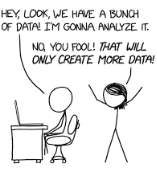

## Part 1

### Data loading
Here we load the data using `pandas`

In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sympy.solvers.ode.single import Bernoulli

In [2]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", na_values='?')
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


## Preprocessing

The data is preprocessed as the following:

* All `NA` rows are dropped
* The salary column is made into 0s and 1s by checking the symbol of `>` being in the string as there were 4 different types of values for that column before : `[<=50K,<=50K.,>50K,>50K.]` and this handles the differences.
* Categorical data is transformed with OneHotEncoder for easier use with the ML models.
* `capital-gain` and `capital-loss` are grouped together under `capital-delta` as they are dependent on each other and encoding their dependency may not get captured by some of the models, hence they are directly encoded with this dependency.
* Continuous features are standardized as the data is assumed to follow a standard distribution as most continuous data points concerning large groups of people are. Moreover, this is also done to prevent feature scaling from causing bias in the models.
* The `sex` column is made to be binary.
* Dimensionality reduction technique PCA was not used as we are using OneHotEncoding and PCA is better suited for only continious features. Since there are not that many continous features either way it was omitted.

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = data.dropna().copy()

df['salary'] = df['salary'].astype(str).apply(lambda x: 1 if '>' in x else 0)

categorical_cols = [
    'marital-status', 'workclass', 'occupation',
    'relationship', 'race', 'native-country'
]
# Capital loss and capital gain represent essentially the exact same information
# Capital delta can represent both at the same time without increasing dimensionality
df['capital-delta'] = df['capital-gain'] - df['capital-loss']


# Education is the same as education-num if it were ordinally encoded.
# Capital loss/gain already encoded with capital delta
df.drop( columns=[ 'education', 'capital-gain', 'capital-loss' ], inplace=True)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
continuous_cols = [x for x in df.columns if x not in categorical_cols and x!='sex' and x != 'salary']
scaler = StandardScaler()
# Column transformer
binary_pipeline = Pipeline(
        [
            ( 'encode', OrdinalEncoder() ),
            ( 'transform', FunctionTransformer( lambda x: 2*x-1 ) )
        ]
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("continuous", scaler, continuous_cols),
        ("binary", binary_pipeline, ['sex'])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)



### Outliers
To get to know our data we will also see the number of outliers for each continous features. For this, we assume that the data is normally distributed. Afterwards, we count the number of features with $p$ value $p\le0.05$ (i.e the data points that fall outside the 90% "confidence interval". Which corresponds to the points $z=1.96$ standard deviations away (or more!) from the mean. Hence outside the range $[-z\cdot\sigma + \mu, z\cdot\sigma + \mu]$. As we can see for the categories `Age`, `Fnlwgt` and `Capital-delta` there are a group of values on the higher range that are considerably higher than the general population and most of the values for that population are low. While f or categories such as `Hours-per-week` and `Education-num` we can see that there are outliers on both tails, indicating that most of the dataset is concentrated around the mean and that there are exceptional groups of people with either an education level much higher or much lower than the average.

In [4]:
def identify_outliers( x, columns ):
    """
    Identify outliers in the specified columns of a DataFrame.
    An outlier is defined as a value that is more than 1.96 standard deviations away from the mean.
    Parameters:
    x (pd.DataFrame): The input DataFrame containing the data.
    columns (list): A list of column names to check for outliers.
    Returns:
    None: Prints the number of low and high outliers for each specified column.
    """
    # write docstring
    for column in columns:
        x_min, x_max = x[column].min(), x[column].max()
        mean, std = x[column].mean(), x[column].std()

        lows = x[column] <= mean - 1.96*std
        highs = x[column] >= mean + 1.96*std
        lows, highs = x[lows], x[highs]

        print( f"{column.capitalize()}:\tLow:\t{lows.shape[0]}\t|\tHigh:\t{highs.shape[0]}" )

In [5]:
identify_outliers(df, continuous_cols)

Age:	Low:	0	|	High:	1561
Fnlwgt:	Low:	0	|	High:	1826
Education-num:	Low:	2242	|	High:	544
Hours-per-week:	Low:	1869	|	High:	1527
Capital-delta:	Low:	0	|	High:	365


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
target_col = 'salary'
data = df.copy()
dataX = data.drop(columns=[target_col])
dataY = data[target_col]

#### Perturbations
In the later parts of the assignment the data will be perturbed. From the assignment description we assumed that the perturbations would be done by flipping the classes of a certain proportion of $f$ of the _test_ data $y$.

In [7]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y, fraction: float) -> np.ndarray:
    y_copy = y.copy()
    n_flip = int(len(y) * fraction)

    # Randomly select indices to flip
    flip_indices = np.random.choice(len(y), size=n_flip, replace=False)
    y_copy.iloc[flip_indices] = 1 ^ y_copy.iloc[flip_indices]

    return y_copy

## Data Visualization
For categorical features we use Cramer's V which is better suited for displaying any correlation between them. For continious features we use Pearson's Correlation as it is well suited.

We can see from the Cramer's V heatmap that the following features together have the highest correlation with salary: `maritial-status`, `occupation`, ,`workclass` and `relationship` so we can expect those to be crucial indicators of salary. We can also see that `age` has a correlation with the rest of the continious features, so we can expect it to be a good representation on the rest of the features, hinting that it could be a useful feature for classification.

In [8]:
from scipy.stats import chi2_contingency
import numpy as np
# ----------------------------
# Visualize correlations
def cramers_V(X, cols):
    """Compute Cramér's V between categorical columns."""
    cramer_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for col1 in cols:
        for col2 in cols:
            conf_mat = pd.crosstab(X[col1], X[col2])
            chi_sq = chi2_contingency(conf_mat)[0]
            n = conf_mat.sum().sum()
            V = chi_sq / (n * (min(conf_mat.shape) - 1))
            cramer_matrix.loc[col1, col2] = np.sqrt(V)
    return cramer_matrix

def visualize(data, preprocessor, categorical_cols=None):
    """Visualize correlations including numeric and categorical (Cramér's V)."""
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Numeric correlation
    corr_numeric = X.corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_numeric, cmap="coolwarm", center=0)
    plt.title("Pearson Correlation Matrix Including Target Variable")
    plt.show()

    # Categorical correlation
    if categorical_cols is not None and len(categorical_cols) > 0:
        cat_cols = categorical_cols.copy()
        if target_col not in cat_cols:
            cat_cols.append(target_col)
        cramer_matrix = cramers_V(data, cat_cols)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cramer_matrix.astype(float), cmap="coolwarm", center=0)
        plt.title("Cramér's V Matrix for Categorical Features")
        plt.show()
    else:
        cramer_matrix = None

    return corr_numeric, cramer_matrix

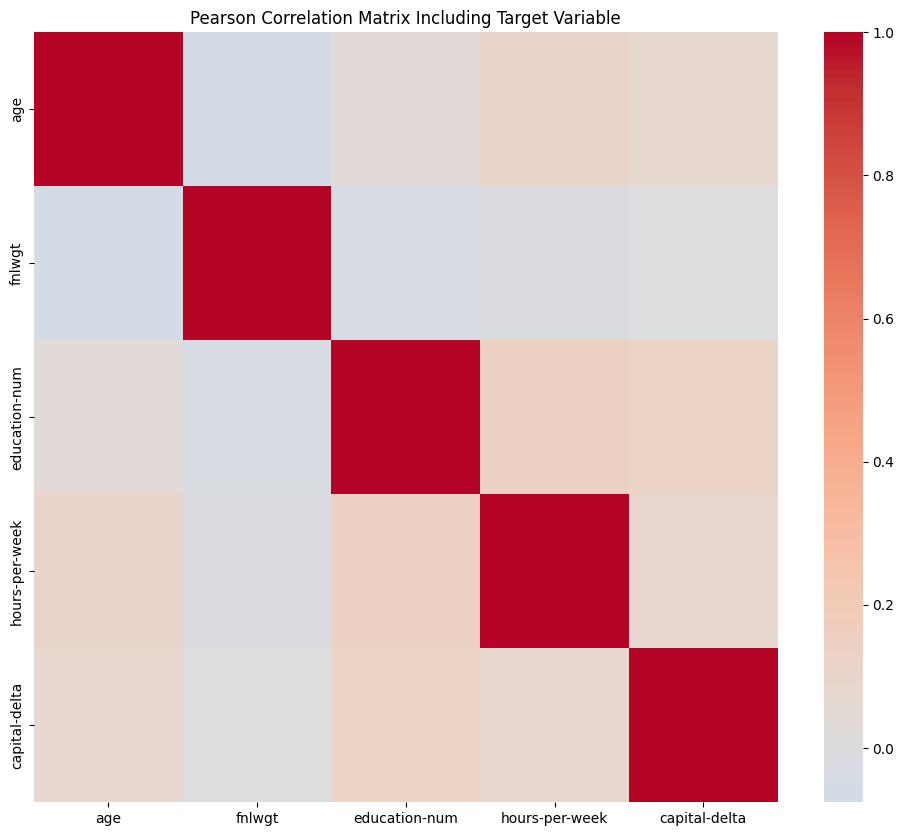

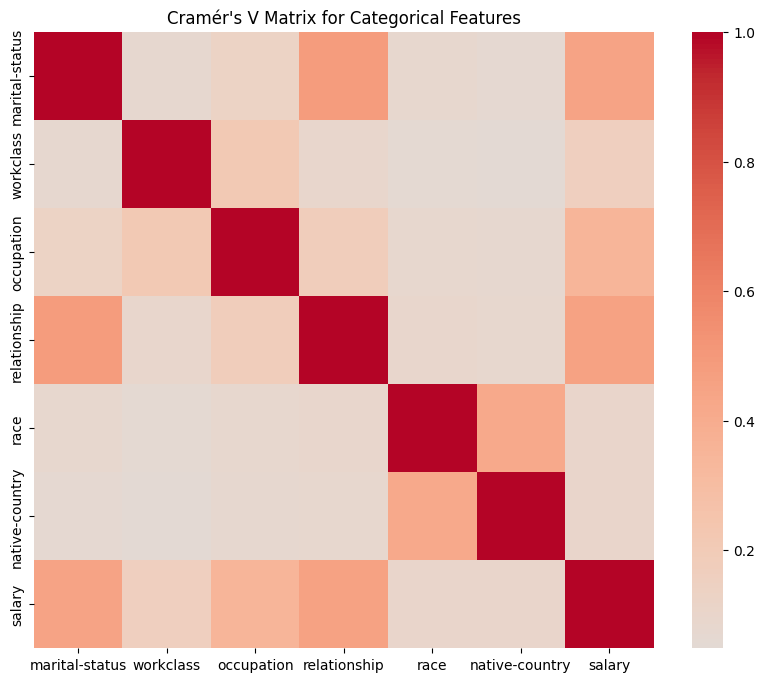

(                     age    fnlwgt  education-num  hours-per-week  \
 age             1.000000 -0.075792       0.037623        0.101992   
 fnlwgt         -0.075792  1.000000      -0.041993       -0.018679   
 education-num   0.037623 -0.041993       1.000000        0.146206   
 hours-per-week  0.101992 -0.018679       0.146206        1.000000   
 capital-delta   0.076239 -0.003864       0.122110        0.080700   
 
                 capital-delta  
 age                  0.076239  
 fnlwgt              -0.003864  
 education-num        0.122110  
 hours-per-week       0.080700  
 capital-delta        1.000000  ,
                 marital-status  workclass  occupation  relationship      race  \
 marital-status        1.000000   0.077422    0.130407      0.487134  0.081836   
 workclass             0.077422   1.000000    0.216938      0.088658  0.059641   
 occupation            0.130407   0.216938    1.000000      0.176946  0.081859   
 relationship          0.487134   0.088658    0.176

In [9]:
visualize(df, preprocessor, categorical_cols)

## Evaluation

To evaluate our results we will be using a 10 fold cross validation to ensure that our evaluation isn't biased and is representative of the model's suitability for the data. The average value of each metric (precision, accuracy, f1 score etc.) will be taken as the "Cross Validation score" of each.

### Perturbations
We also pre-emptatively include a `perturb_fraction` parameter for the later parts of the assignment. We assumed that the users misentering their data would be represented by the test dataset's classes being perturbed (and hence different from the actual values in the training). So in a fold, the perturbations were only performed on the _test data_ rather than the training data to represent how the model would be impacted in a scenario in which the training data is correct (as it is usually from carefully collected sets) but in practice due to user error the model can misbehave.

In [10]:
# ----------------------------
# Apply your model
def apply_model(model, X, y, n_splits = 10 , perturb_fraction = 0.0,verbose = True):
    """Apply the model with cross-validation and optional label perturbation.
    """
    pipeline = Pipeline(steps=[('t', preprocessor), ('m', model)])
    # Evaluate on test set
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    results = []
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
         results.append(evaluate_model(X, y, pipeline,train_idx,test_idx, perturb_fraction))
    avg = {k: sum(d[k] for d in results) / len(results) for k in results[0]}
    for metric in avg:
        if verbose:
            print(f'    Mean {metric} : {avg[metric]}')

    return avg

# ----------------------------
# Evaluate model
def evaluate_model(X, y, pipeline, train_idx, test_idx, perturb_fraction = 0.0):
    """Evaluate the model on a train/test split with optional label perturbation.
    """
    results = {}
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    # Perturb
    y_test = pertubate(y_test,perturb_fraction)
    pipeline.fit(X_train, y_train)
    # Predict on test split
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    

    return results

## Model Selection

The following models were selected:
* Logistic Regression
* Naive Bayes
* K-Nearest Neighbours
* Gradient Boosting

These were chosen to be vastly different types of classifiers from each other in how they work. Hence choosing them to be distinct from each other allows us to view their suitability in helping with the problem seperately, giving us multiple perspective on the problem (especially with the perturbations) and ultimately giving more insight.
### Expectations 

We expect Naive Bayes to perform the poorest out of all models as it assumes no dependence between features (which as we saw from the data visualization is incorrect), this however might turn out to be an advantage for when there are more perturbations and hence the classes are independent. Logistic Regression we expect to perform quite well as we expect there to be a linear relationship in our data. We expect KNN and Gradient Boosting to perform worse as the perturbation rate increases as they can be both prone to overfitting. Since we preprocess our data, KNN should not be biased by feature scaling.

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


models = [LogisticRegression(), 
          BernoulliNB(), 
          KNeighborsClassifier(), 
          GradientBoostingClassifier(random_state=42)]
dataY = dataY.astype(int)
for m in models:
    print(f'Model {m.__class__.__name__}:')
    apply_model(m, dataX, dataY)

Model LogisticRegression:
    Mean Accuracy : 0.843195782566142
    Mean Precision : 0.8366276197652308
    Mean Recall : 0.843195782566142
    Mean F1 Score : 0.8377441160981871
Model BernoulliNB:
    Mean Accuracy : 0.7600724167391336
    Mean Precision : 0.8157751251641386
    Mean Recall : 0.7600724167391336
    Mean F1 Score : 0.7740408520369587
Model KNeighborsClassifier:
    Mean Accuracy : 0.8275618508105851
    Mean Precision : 0.8213435919512133
    Mean Recall : 0.8275618508105851
    Mean F1 Score : 0.8233687285898998
Model GradientBoostingClassifier:
    Mean Accuracy : 0.8630754667553513
    Mean Precision : 0.8580490219195205
    Mean Recall : 0.8630754667553513
    Mean F1 Score : 0.8566083974953296


## Initial Experiment
From our initial experiment we can see that Naive Bayes does indeed perform the worst out of all the models like we expected and grading boosting performs the best, followed closely by logistic regression.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


fractions = np.arange(0.0, 0.6, 0.1)  # 0, 0.1, ..., 0.5
n_folds = 10
n_repeats = 5
X = df.drop(columns=[target_col])
y = df[target_col]

pert_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "BernoulliNB": BernoulliNB(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

results = {model_name: [] for model_name in pert_models.keys()}

for frac in fractions:
    frac_results = {model_name: [] for model_name in pert_models.keys()}
    print(f"Fraction: {frac:.1f}")
    for repeat_no in range(n_repeats):
        print(f' Iteration:{repeat_no+1}')
        for model_name, model in pert_models.items():
            print(f'  Model: {model_name}')
            score = apply_model(model, X, y,n_folds,frac)
            frac_results[model_name].append(score["Accuracy"])

    # Store mean and variance
    for model_name in pert_models.keys():
        mean_score = np.mean(frac_results[model_name])
        var_score = np.var(frac_results[model_name])
        results[model_name].append((mean_score, var_score))



Fraction: 0.0
 Iteration:1
  Model: Logistic Regression
    Mean Accuracy : 0.843195782566142
    Mean Precision : 0.8366276197652308
    Mean Recall : 0.843195782566142
    Mean F1 Score : 0.8377441160981871
  Model: BernoulliNB
    Mean Accuracy : 0.7600724167391336
    Mean Precision : 0.8157751251641386
    Mean Recall : 0.7600724167391336
    Mean F1 Score : 0.7740408520369587
  Model: KNN
    Mean Accuracy : 0.8275618508105851
    Mean Precision : 0.8213435919512133
    Mean Recall : 0.8275618508105851
    Mean F1 Score : 0.8233687285898998
  Model: Gradient Boosting
    Mean Accuracy : 0.8630754667553513
    Mean Precision : 0.8580476467880823
    Mean Recall : 0.8630754667553513
    Mean F1 Score : 0.8566086738411153
 Iteration:2
  Model: Logistic Regression
    Mean Accuracy : 0.843195782566142
    Mean Precision : 0.8366276197652308
    Mean Recall : 0.843195782566142
    Mean F1 Score : 0.8377441160981871
  Model: BernoulliNB
    Mean Accuracy : 0.7600724167391336
    Mean P

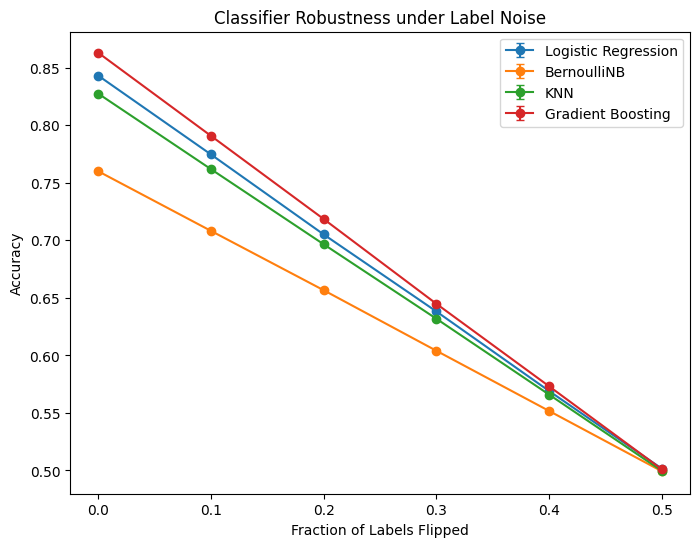

In [15]:
# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
for model_name, scores in results.items():
    means = [m for m, v in scores]
    vars_ = [v for m, v in scores]
    plt.errorbar(fractions, means, yerr=np.sqrt(vars_), label=model_name, capsize=3, marker="o")

plt.xlabel("Fraction of Labels Flipped")
plt.ylabel("Accuracy")
plt.title("Classifier Robustness under Label Noise")
plt.legend()
plt.show()


In [16]:
results

{'Logistic Regression': [(np.float64(0.843195782566142), np.float64(0.0)),
  (np.float64(0.7746804279038495), np.float64(1.1292288272231809e-06)),
  (np.float64(0.7051391272265798), np.float64(2.5006345779323916e-06)),
  (np.float64(0.638180480658931), np.float64(2.716234331214359e-06)),
  (np.float64(0.569046144121798), np.float64(9.299642370662337e-07)),
  (np.float64(0.5015568449938362), np.float64(8.617788302564733e-07))],
 'BernoulliNB': [(np.float64(0.7600724167391336), np.float64(0.0)),
  (np.float64(0.7082481088598908), np.float64(5.025364162097533e-07)),
  (np.float64(0.6566627174509214), np.float64(1.7912837466948862e-06)),
  (np.float64(0.604033495125362), np.float64(1.3280228509091329e-06)),
  (np.float64(0.5517137588479659), np.float64(3.4506378620914422e-06)),
  (np.float64(0.4993056306735547), np.float64(1.6278966282950541e-06))],
 'KNN': [(np.float64(0.8275618508105851), np.float64(0.0)),
  (np.float64(0.7618947170895075), np.float64(1.943609065033252e-07)),
  (np.float

# TODO
#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

Observations + explanations: max. 400 words


# Discussion
Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels.


## 1. Reducing the Impact of Wrongly Labelled Data

- **Perturb the training data:**  
  By perturbing the training data, the model trained on it is forced to learn smoother patterns, making it more robust to perturbations in the test data as well.

- **Use models that naturally downplay noisy samples:**  
  Gradient Boosting, for example, is naturally more resilient to noise because it is built up of multiple weak learners. Other classifiers that might be worth looking into for this inherent ability are Random Forests and Bayesian Neural Networks.

- **Train more robust models:**  
  - **Regularization:** Similarly to perturbing the training data, regularization can prevent the model from fitting onto outliers too much.  
  - **Reducing model complexity:** Another way is to tweak the used model to avoid overfitting by making it less complex. A logical starting point would be Gradient Boosting, as it is currently our best-performing classifier. The robustness of Gradient Boosting can be increased in many ways, for example by pruning to a relatively small tree depth, which is shown to increase robustness while barely decreasing accuracy [1].  

---

## 2. Correct Wrong Labels
In correcting wrong labels there is always the risk of reinforcing biases and therefore underfitting some minority relationships. It can, however, reduce the noise of the dataset. Here are some ways to correct wrong labels in our dataset:

- **Outlier detection:**  
  A point that is far away from points with the same label in the feature space can be an outlier. Given that Gradient Boosting, a tree-based classifier, performed best on our dataset, it suggests that tree-based approaches are particularly effective for capturing the underlying structure of our data. An Isolation Forest, which is also tree-based but specialized for outlier detection, might therefore be a promising method for identifying incorrectly labelled samples. This is further supported by what the creators of the Isolation Forest say: *“iForest also works well in high dimensional problems which have a large number of irrelevant attributes”* [2]. Our dataset also has many irrelevant attributes, supporting this claim.

- **Consensus across models technique:**  
  If the different models we use all misclassify the same data point, we might assume it is labelled incorrectly.  

- **Human in the loop:**  
  It might be possible to check some outliers manually. This can be very accurate in some cases. For example, a human could easily check if it makes sense for a heart surgeon living in Monaco to have a salary of less than 50K. The downside, of course, is that it is both expensive and prone to human error.  

##### References
1: Isolation Forest. (2008, December 1). IEEE Conference Publication | IEEE Xplore. https://ieeexplore.ieee.org/abstract/document/4781136

2:Einziger, G., Goldstein, M., Sa’ar, Y., & Segall, I. (2019). Verifying Robustness of Gradient Boosted Models. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01), 2446–2453. https://doi.org/10.1609/aaai.v33i01.33012446

## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



In [ ]:

def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """
    unionss = find_union_candidates(load_datasets(f'lake49/'))
    joinss = find_join_candidates(load_datasets(f'lake49/'))


In [ ]:
discovery_algorithm()



In [ ]:
unionss

In [ ]:
joinss

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words